## Load libraries

In [1]:
import os, sys

# add parent directory to path
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [3]:
df = pd.read_parquet(os.path.join("..", "data", "train_3dpes.parquet"))

In [4]:
# Calculate hip distance between LEFT_HIP and RIGHT_HIP using only x coordinate
df["HIP_DISTANCE"] = abs(df["RIGHT_HIP_x"] - df["LEFT_HIP_x"])

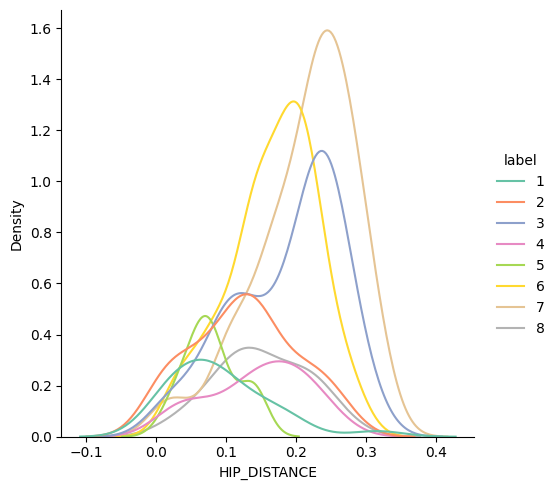

In [5]:
#plot the distribution of hip distance and color based on the label
sns.displot(df, x="HIP_DISTANCE", hue="label", kind="kde", palette="Set2")
plt.show()

In [6]:
columns = [column for column in df.columns if "SHOULDER" in column] + [column for column in df.columns if "HIP" in column]

In [7]:
df = df[columns]

In [8]:
vectors = []

# iterate over all rows
for index, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    visibility_dict = dict()
    for column in row.index:
        if "visibility" in column:
            visibility_dict[column] = row[column]

    # get top 3 most visible joints
    # top_3 = sorted(visibility_dict, key=visibility_dict.get, reverse=True)[:3]
    top_3 = list(visibility_dict.keys())[:3]

    # eliminate "visibility" from column names
    top_3 = [column.replace("_visibility", "") for column in top_3]

    joints: np.ndarray = np.empty((3, 3))

    for joint_column in top_3:
        # get x, y and z coordinates and put them in a numpy array
        joint_coordinates = np.array([row[joint_column + "_x"], row[joint_column + "_y"], row[joint_column + "_z"]])

        # add the coordinates to the joints array
        joints[top_3.index(joint_column)] = joint_coordinates

    # calculate the normal vector of the plane defined by the top 3 most visible joints
    normal_vector = np.cross(joints[1] - joints[0], joints[2] - joints[0])
    
    # normalize the normal vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)

    vectors.append(normal_vector)

    # # calculate the angle between the normal vector and the z-axis
    # angle = np.arccos(normal_vector[2] / np.linalg.norm(normal_vector))

    # # convert the angle to degrees
    # angle = np.degrees(angle)

    # # add the angle to the angles series
    # angles.append(angle)

vectors = np.array(vectors)

100%|██████████| 491/491 [00:00<00:00, 8465.61it/s]


In [9]:
df = pd.read_parquet(os.path.join("..", "data", "train_3dpes.parquet"))

In [10]:
df["normal_vector_x"] = vectors[:, 0]
df["normal_vector_y"] = vectors[:, 1]
df["normal_vector_z"] = vectors[:, 2]

In [11]:
df

name,NOSE_x,LEFT_EYE_INNER_x,LEFT_EYE_x,LEFT_EYE_OUTER_x,RIGHT_EYE_INNER_x,RIGHT_EYE_x,RIGHT_EYE_OUTER_x,LEFT_EAR_x,RIGHT_EAR_x,MOUTH_LEFT_x,...,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_visibility,filename,img_height,img_width,label,normal_vector_x,normal_vector_y,normal_vector_z
file_count,,,,,,,,,,,,,,,,,,,,,
0.0,0.784383,0.795862,0.804042,0.811186,0.771800,0.762776,0.754197,0.821808,0.742224,0.797042,...,0.449096,0.545455,0.660193,102_23_FRAME_12_RGB.bmp,189,135,7,-0.242651,0.929976,-0.276161
1.0,0.514450,0.525540,0.538651,0.551545,0.495063,0.485213,0.474640,0.587439,0.480625,0.543584,...,0.467985,0.515640,0.809789,102_23_FRAME_54_RGB.bmp,183,75,6,-0.031655,0.962126,-0.270762
2.0,0.596065,0.622891,0.642344,0.658734,0.564028,0.547535,0.533123,0.684341,0.516567,0.638584,...,0.554134,0.878325,0.723066,102_26_FRAME_85_RGB.bmp,120,39,6,-0.108268,0.941077,-0.320393
3.0,0.678144,0.685466,0.684164,0.682298,0.690156,0.690966,0.692118,0.678675,0.694333,0.669507,...,0.651741,0.790947,0.802804,104_53_FRAME_103_RGB.bmp,156,56,2,0.023443,-0.986450,-0.162378
4.0,0.776119,0.762512,0.752715,0.742342,0.784705,0.790155,0.795267,0.718975,0.793387,0.757359,...,0.683384,0.418380,0.296281,104_53_FRAME_70_RGB.bmp,237,130,2,0.936984,-0.014984,0.349051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486.0,0.526797,0.553086,0.570027,0.586724,0.519070,0.507619,0.497154,0.624617,0.510767,0.553512,...,0.803484,0.920780,0.908565,98_845_FRAME_99_RGB.bmp,126,55,6,-0.872811,0.426021,-0.238132
487.0,0.460099,0.483845,0.503176,0.522873,0.431644,0.412627,0.393493,0.554600,0.375764,0.502140,...,0.019161,0.021013,0.021215,9_859_FRAME_148_RGB.bmp,144,51,7,0.002209,0.944016,-0.329893
488.0,0.470837,0.488221,0.503243,0.515891,0.429539,0.409857,0.394204,0.537908,0.365208,0.499363,...,0.989557,0.999997,0.995642,9_888_FRAME_22_RGB.bmp,264,128,8,0.265152,0.958571,-0.104099


In [12]:
# plot normal vectors with labels on a sphere with seaborn
import plotly.express as px

fig = px.scatter_3d(df, x="normal_vector_x", y="normal_vector_y", z="normal_vector_z", color="label", opacity=0.5, width=1000, height=1000)

fig.show()